# Data Visualization using test.db


In [1]:
import sqlite3
from tabulate import tabulate

def view_database():
    """SQLite database का data दिखाओ"""
    
    # Database connect करो
    conn = sqlite3.connect('test.db')
    cursor = conn.cursor()
    
    # सारी tables की list लो
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    print("=" * 50)
    print("📊 DATABASE TABLES")
    print("=" * 50)
    
    for table in tables:
        table_name = table[0]
        print(f"\n📁 Table: {table_name}")
        print("-" * 30)
        
        # Table ka data लो
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()
        
        # Column names लो
        cursor.execute(f"PRAGMA table_info({table_name})")
        columns = [col[1] for col in cursor.fetchall()]
        
        if rows:
            # Data show करो
            print(tabulate(rows, headers=columns, tablefmt='grid'))
            print(f"📝 Total rows: {len(rows)}")
        else:
            print("📭 No data in table")
    
    conn.close()

# Run karo
if __name__ == "__main__":
    view_database()

📊 DATABASE TABLES

📁 Table: users
------------------------------
+------+-----------+------------------+---------------------+
|   id | name      | email            | created_at          |
+======+===========+==================+=====================+
|    1 | Duplicate |                  | 2026-02-19 16:42:22 |
+------+-----------+------------------+---------------------+
|    2 | John      |                  | 2026-02-20 12:20:27 |
+------+-----------+------------------+---------------------+
|    3 | User935   | user152@test.com | 2026-02-20 13:41:40 |
+------+-----------+------------------+---------------------+
|    4 | User157   | user98@test.com  | 2026-02-20 13:41:42 |
+------+-----------+------------------+---------------------+
|    5 | User97    | user299@test.com | 2026-02-20 13:43:21 |
+------+-----------+------------------+---------------------+
|    6 | User730   | user626@test.com | 2026-02-20 13:43:28 |
+------+-----------+------------------+---------------------+
|    

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_errors():
    """Error data का analysis करो"""
    
    conn = sqlite3.connect('test.db')
    
    # SQL query से statistics निकालो
    df = pd.read_sql_query("""
        SELECT 
            error_type,
            category,
            COUNT(*) as count,
            MIN(timestamp) as first_seen,
            MAX(timestamp) as last_seen
        FROM error_simulation_logs
        GROUP BY error_type, category
        ORDER BY count DESC
    """, conn)
    
    print("\n" + "="*60)
    print("📊 ERROR STATISTICS")
    print("="*60)
    
    total = df['count'].sum()
    print(f"\n📈 Total Errors: {total}")
    
    for _, row in df.iterrows():
        percentage = (row['count'] / total) * 100
        print(f"\n{row['category']} - {row['error_type']}:")
        print(f"  📍 Count: {row['count']} ({percentage:.1f}%)")
        print(f"  📅 First: {row['first_seen']}")
        print(f"  📅 Last: {row['last_seen']}")
    
    # Category-wise distribution
    print("\n" + "="*60)
    print("📊 CATEGORY WISE BREAKDOWN")
    print("="*60)
    
    cat_df = df.groupby('category')['count'].sum().reset_index()
    for _, row in cat_df.iterrows():
        percentage = (row['count'] / total) * 100
        print(f"{row['category']}: {row['count']} ({percentage:.1f}%)")
    
    conn.close()
    return df

# Run analysis
stats = analyze_errors()


📊 ERROR STATISTICS

📈 Total Errors: 612

200 - HTTP:
  📍 Count: 430 (70.3%)
  📅 First: 2026-02-19 22:12:03.297978
  📅 Last: 2026-02-20 19:34:56.167261

timeout - EXTERNAL:
  📍 Count: 35 (5.7%)
  📅 First: 2026-02-19 22:12:44.057557
  📅 Last: 2026-02-20 19:34:17.676092

validation - BUSINESS:
  📍 Count: 33 (5.4%)
  📅 First: 2026-02-19 22:12:40.051924
  📅 Last: 2026-02-20 19:35:03.727096

404 - HTTP:
  📍 Count: 31 (5.1%)
  📅 First: 2026-02-19 22:12:35.150652
  📅 Last: 2026-02-20 19:34:46.280638

slow_query - PERFORMANCE:
  📍 Count: 27 (4.4%)
  📅 First: 2026-02-19 22:12:00.691635
  📅 Last: 2026-02-20 19:32:31.473939

500 - HTTP:
  📍 Count: 24 (3.9%)
  📅 First: 2026-02-19 22:12:15.522372
  📅 Last: 2026-02-20 19:34:43.432091

403 - HTTP:
  📍 Count: 21 (3.4%)
  📅 First: 2026-02-19 22:12:16.224567
  📅 Last: 2026-02-20 19:34:59.746892

429 - HTTP:
  📍 Count: 8 (1.3%)
  📅 First: 2026-02-20 19:06:00.188661
  📅 Last: 2026-02-20 19:26:57.289322

state - BUSINESS:
  📍 Count: 3 (0.5%)
  📅 First: 202

In [3]:
def time_series_analysis():
    """समय के साथ error pattern देखो"""
    
    conn = sqlite3.connect('test.db')
    
    # हर minute में errors count करो
    df = pd.read_sql_query("""
        SELECT 
            strftime('%Y-%m-%d %H:%M', timestamp) as minute,
            error_type,
            category,
            COUNT(*) as error_count
        FROM error_simulation_logs
        GROUP BY minute, error_type, category
        ORDER BY minute DESC
    """, conn)
    
    # Convert to datetime
    df['minute'] = pd.to_datetime(df['minute'])
    
    # Pivot table बनाओ
    pivot = df.pivot_table(
        values='error_count', 
        index='minute', 
        columns='category',
        aggfunc='sum',
        fill_value=0
    )
    
    print("\n" + "="*60)
    print("📊 TIME SERIES ANALYSIS (Last 10 minutes)")
    print("="*60)
    
    print(pivot.tail(10))
    
    # Calculate moving averages
    pivot['total'] = pivot.sum(axis=1)
    pivot['ma_3'] = pivot['total'].rolling(window=3).mean()
    pivot['ma_5'] = pivot['total'].rolling(window=5).mean()
    
    print("\n📈 Moving Averages (Last 10):")
    print(pivot[['total', 'ma_3', 'ma_5']].tail(10))
    
    # Detect anomalies (sudden spikes)
    pivot['mean'] = pivot['total'].expanding().mean()
    pivot['std'] = pivot['total'].expanding().std()
    pivot['is_anomaly'] = abs(pivot['total'] - pivot['mean']) > 2 * pivot['std']
    
    anomalies = pivot[pivot['is_anomaly'] == True]
    if not anomalies.empty:
        print("\n🚨 ANOMALIES DETECTED:")
        print(anomalies[['total', 'mean', 'std']])
    
    conn.close()
    return pivot

timeseries = time_series_analysis()


📊 TIME SERIES ANALYSIS (Last 10 minutes)
category             200  403  404  429  500  slow_query  state  timeout  \
minute                                                                     
2026-02-20 19:26:00   10    0    2    1    0           0      0        1   
2026-02-20 19:27:00    8    0    1    0    2           4      0        0   
2026-02-20 19:28:00   14    0    0    0    0           0      0        1   
2026-02-20 19:29:00    9    0    1    0    0           0      0        2   
2026-02-20 19:30:00   19    0    0    0    0           0      0        1   
2026-02-20 19:31:00    9    0    0    0    2           0      0        1   
2026-02-20 19:32:00   11    0    0    0    0           2      0        1   
2026-02-20 19:33:00   12    0    0    0    1           0      0        1   
2026-02-20 19:34:00   11    1    2    0    1           0      0        1   
2026-02-20 19:35:00    0    0    0    0    0           0      0        0   

category             validation  
minute     

In [4]:
def error_rate_analysis():
    """Success vs Failure ratio निकालो"""
    
    conn = sqlite3.connect('test.db')
    
    # Success vs Failure
    df = pd.read_sql_query("""
        SELECT 
            CASE 
                WHEN error_type IN ('200', 'success') THEN 'SUCCESS'
                ELSE 'ERROR'
            END as status,
            COUNT(*) as count
        FROM error_simulation_logs
        GROUP BY status
    """, conn)
    
    total = df['count'].sum()
    
    print("\n" + "="*60)
    print("📊 SUCCESS VS ERROR RATE")
    print("="*60)
    
    for _, row in df.iterrows():
        percentage = (row['count'] / total) * 100
        bar = '█' * int(percentage/2)
        print(f"{row['status']}: {row['count']:4d} ({percentage:5.1f}%) {bar}")
    
    # Error rate by category
    print("\n📊 ERROR RATE BY CATEGORY")
    print("="*60)
    
    error_df = pd.read_sql_query("""
        SELECT 
            category,
            COUNT(*) as errors
        FROM error_simulation_logs
        WHERE error_type NOT IN ('200', 'success')
        GROUP BY category
        ORDER BY errors DESC
    """, conn)
    
    for _, row in error_df.iterrows():
        percentage = (row['errors'] / total) * 100
        bar = '█' * int(percentage)
        print(f"{row['category']:12s}: {row['errors']:4d} ({percentage:5.1f}%) {bar}")
    
    conn.close()

error_rate_analysis()


📊 SUCCESS VS ERROR RATE
ERROR:  612 (100.0%) ██████████████████████████████████████████████████

📊 ERROR RATE BY CATEGORY
200         :  430 ( 70.3%) ██████████████████████████████████████████████████████████████████████
timeout     :   35 (  5.7%) █████
validation  :   33 (  5.4%) █████
404         :   31 (  5.1%) █████
slow_query  :   27 (  4.4%) ████
500         :   24 (  3.9%) ███
403         :   21 (  3.4%) ███
429         :    8 (  1.3%) █
state       :    3 (  0.5%) 


In [5]:
# %% [markdown]
# # 📊 Anomaly Detection Data Analysis
# ## Database: test.db

# %% [code]
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

# Connect to database
conn = sqlite3.connect('test.db')

# Load all data
df = pd.read_sql_query("""
    SELECT 
        id,
        error_type,
        category,
        timestamp,
        details
    FROM error_simulation_logs
    ORDER BY timestamp
""", conn)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.floor('min')
df['date'] = df['timestamp'].dt.date

print(f"✅ Total Records: {len(df)}")
print(f"✅ Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"✅ Unique Categories: {df['category'].nunique()}")
print(f"✅ Unique Error Types: {df['error_type'].nunique()}")

df.head()

✅ Total Records: 612
✅ Date Range: 2026-02-19 22:12:00.691635 to 2026-02-20 19:35:03.727096
✅ Unique Categories: 9
✅ Unique Error Types: 4


,id,error_type,category,timestamp,details,hour,minute,date
0,1,PERFORMANCE,slow_query,2026-02-19 22:12:00.691635,Query took >500ms,22,2026-02-19 22:12:00,2026-02-19
1,2,HTTP,200,2026-02-19 22:12:03.297978,✅ Success,22,2026-02-19 22:12:00,2026-02-19
2,3,HTTP,200,2026-02-19 22:12:05.783938,✅ Success,22,2026-02-19 22:12:00,2026-02-19
3,4,HTTP,200,2026-02-19 22:12:10.011628,✅ Success,22,2026-02-19 22:12:00,2026-02-19
4,5,HTTP,200,2026-02-19 22:12:13.804699,✅ Success,22,2026-02-19 22:12:00,2026-02-19


In [6]:
# %% [markdown]
# ## 📊 Basic Statistics

# %% [code]
# Overall statistics
print("="*60)
print("OVERALL STATISTICS")
print("="*60)

total = len(df)
success = len(df[df['error_type'] == '200'])
errors = total - success

print(f"Total Events: {total}")
print(f"Success (200): {success} ({success/total*100:.1f}%)")
print(f"Errors: {errors} ({errors/total*100:.1f}%)")
print()

# By category
print("\n" + "="*60)
print("BY CATEGORY")
print("="*60)
category_stats = df.groupby('category').agg({
    'error_type': 'count',
    'id': 'nunique'
}).rename(columns={'error_type': 'count', 'id': 'unique_errors'})
category_stats['percentage'] = category_stats['count'] / total * 100
print(category_stats.sort_values('count', ascending=False))

# By error type
print("\n" + "="*60)
print("TOP 10 ERROR TYPES")
print("="*60)
error_stats = df.groupby(['category', 'error_type']).size().reset_index(name='count')
error_stats = error_stats.sort_values('count', ascending=False).head(10)
print(error_stats.to_string(index=False))

OVERALL STATISTICS
Total Events: 612
Success (200): 0 (0.0%)
Errors: 612 (100.0%)


BY CATEGORY
            count  unique_errors  percentage
category                                    
200           430            430   70.261438
timeout        35             35    5.718954
validation     33             33    5.392157
404            31             31    5.065359
slow_query     27             27    4.411765
500            24             24    3.921569
403            21             21    3.431373
429             8              8    1.307190
state           3              3    0.490196

TOP 10 ERROR TYPES
  category  error_type  count
       200        HTTP    430
   timeout    EXTERNAL     35
validation    BUSINESS     33
       404        HTTP     31
slow_query PERFORMANCE     27
       500        HTTP     24
       403        HTTP     21
       429        HTTP      8
     state    BUSINESS      3


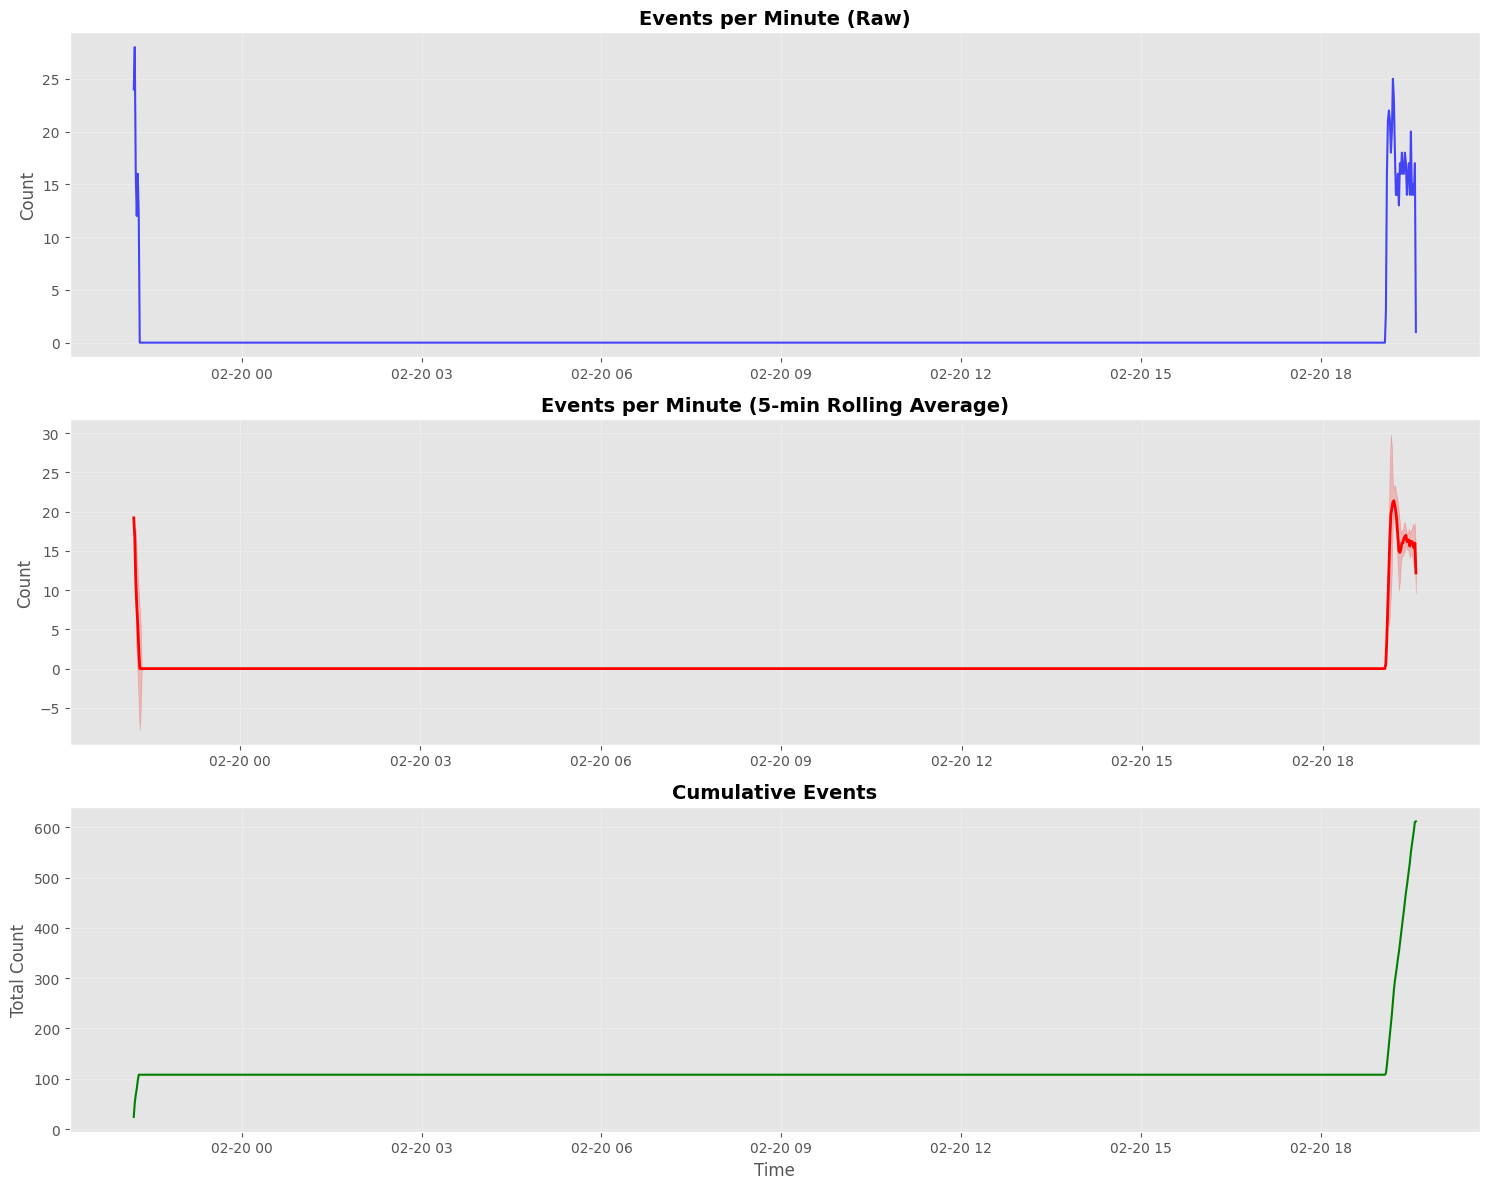

In [7]:
# %% [markdown]
# ## 📈 Time Series Analysis

# %% [code]
# Time series by minute
minute_data = df.groupby('minute').size().reset_index(name='count')
minute_data.set_index('minute', inplace=True)

# Fill missing minutes
full_range = pd.date_range(
    start=minute_data.index.min(), 
    end=minute_data.index.max(), 
    freq='1min'
)
minute_data = minute_data.reindex(full_range, fill_value=0)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Raw data
axes[0].plot(minute_data.index, minute_data['count'], color='blue', alpha=0.7)
axes[0].set_title('Events per Minute (Raw)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# Rolling average
minute_data['rolling_avg'] = minute_data['count'].rolling(window=5, center=True).mean()
axes[1].plot(minute_data.index, minute_data['rolling_avg'], color='red', linewidth=2)
axes[1].fill_between(
    minute_data.index, 
    minute_data['rolling_avg'] - minute_data['count'].rolling(window=5).std(),
    minute_data['rolling_avg'] + minute_data['count'].rolling(window=5).std(),
    alpha=0.2, color='red'
)
axes[1].set_title('Events per Minute (5-min Rolling Average)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

# Cumulative
axes[2].plot(minute_data.index, minute_data['count'].cumsum(), color='green')
axes[2].set_title('Cumulative Events', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Total Count')
axes[2].set_xlabel('Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

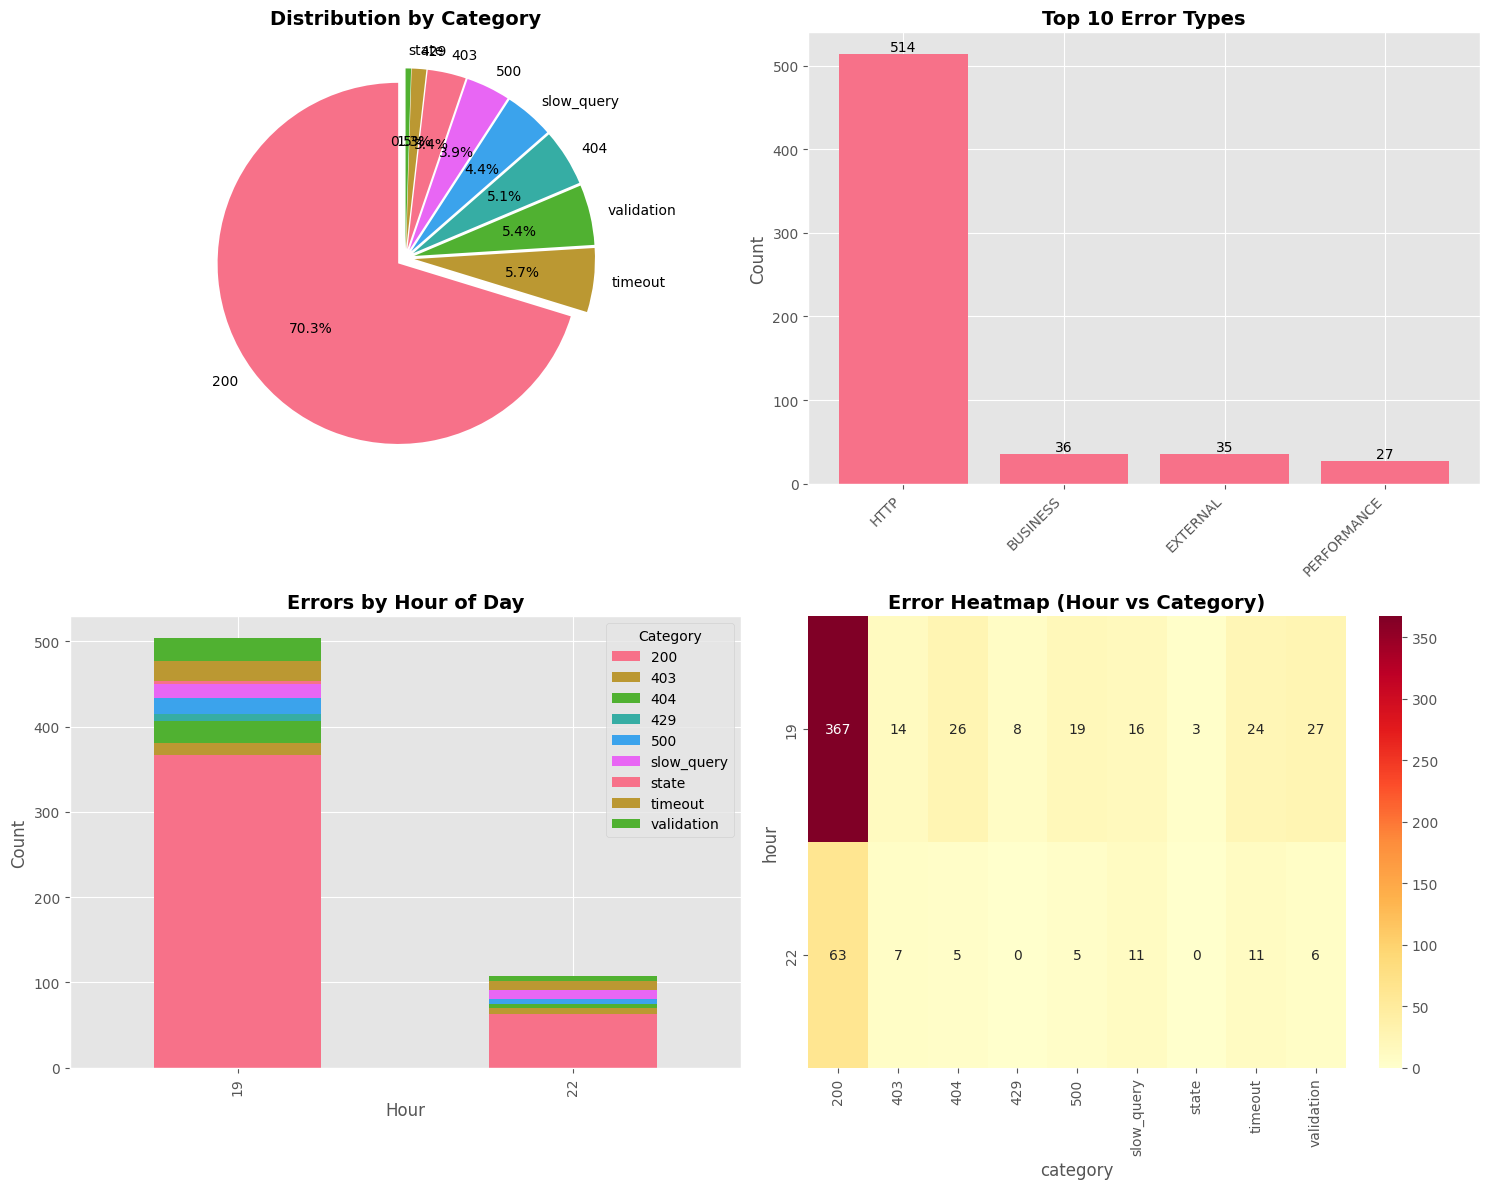

In [8]:
# %% [markdown]
# ## 📊 Error Distribution

# %% [code]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Pie chart - Categories
category_counts = df['category'].value_counts()
axes[0,0].pie(
    category_counts.values, 
    labels=category_counts.index, 
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.05] * len(category_counts)
)
axes[0,0].set_title('Distribution by Category', fontsize=14, fontweight='bold')

# 2. Bar chart - Top error types
top_errors = df['error_type'].value_counts().head(10)
bars = axes[0,1].bar(range(len(top_errors)), top_errors.values)
axes[0,1].set_xticks(range(len(top_errors)))
axes[0,1].set_xticklabels(top_errors.index, rotation=45, ha='right')
axes[0,1].set_title('Top 10 Error Types', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Count')

# Add value labels
for bar, value in zip(bars, top_errors.values):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{value}', ha='center', va='bottom')

# 3. Stacked bar - Category by hour
hour_category = pd.crosstab(df['hour'], df['category'])
hour_category.plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Errors by Hour of Day', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(title='Category')

# 4. Heatmap - Error patterns
pivot_table = pd.pivot_table(
    df, 
    values='id', 
    index='hour', 
    columns='category', 
    aggfunc='count', 
    fill_value=0
)
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1,1])
axes[1,1].set_title('Error Heatmap (Hour vs Category)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

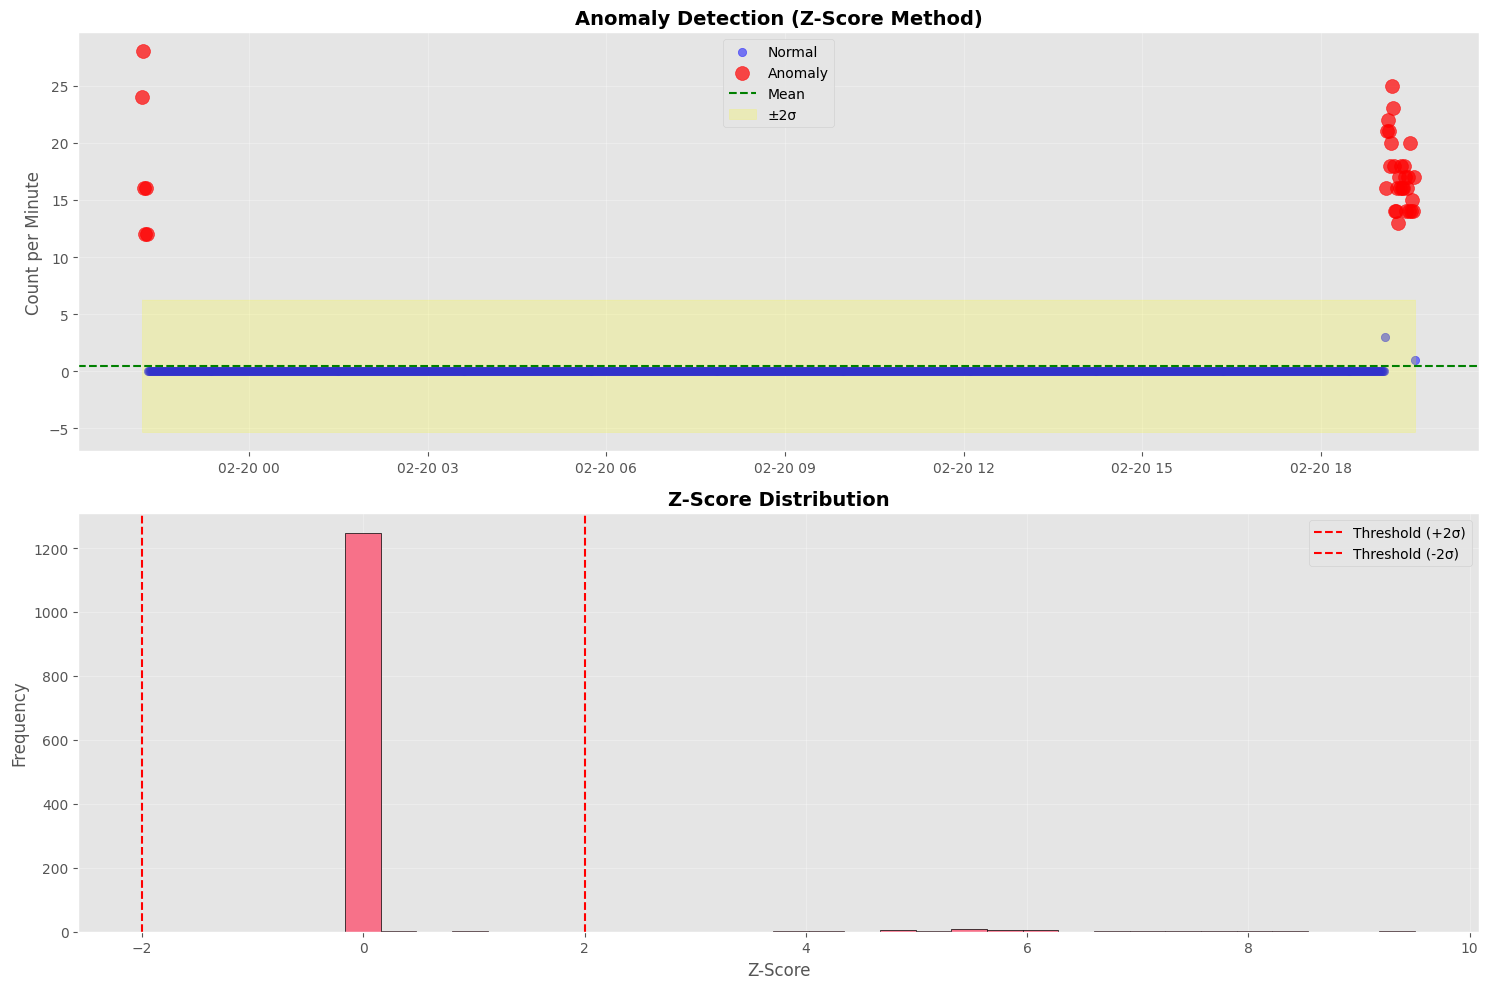

✅ Detected 35 anomalous minutes
✅ Anomaly rate: 2.73%


In [9]:
# %% [markdown]
# ## 🔍 Anomaly Detection Analysis

# %% [code]
# Calculate Z-scores for anomaly detection
def detect_anomalies(data, threshold=2):
    """Detect anomalies using Z-score method"""
    mean = data['count'].mean()
    std = data['count'].std()
    data['z_score'] = (data['count'] - mean) / std
    data['is_anomaly'] = abs(data['z_score']) > threshold
    return data

# Apply to minute data
minute_anomalies = detect_anomalies(minute_data.copy())

# Plot anomalies
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Normal vs Anomaly
normal = minute_anomalies[~minute_anomalies['is_anomaly']]
anomaly = minute_anomalies[minute_anomalies['is_anomaly']]

axes[0].scatter(normal.index, normal['count'], c='blue', label='Normal', alpha=0.5)
axes[0].scatter(anomaly.index, anomaly['count'], c='red', s=100, label='Anomaly', alpha=0.7)
axes[0].axhline(y=minute_anomalies['count'].mean(), color='green', linestyle='--', label='Mean')
axes[0].fill_between(
    minute_anomalies.index,
    minute_anomalies['count'].mean() - 2*minute_anomalies['count'].std(),
    minute_anomalies['count'].mean() + 2*minute_anomalies['count'].std(),
    alpha=0.2, color='yellow', label='±2σ'
)
axes[0].set_title('Anomaly Detection (Z-Score Method)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count per Minute')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Z-score distribution
axes[1].hist(minute_anomalies['z_score'].dropna(), bins=30, edgecolor='black')
axes[1].axvline(x=2, color='red', linestyle='--', label='Threshold (+2σ)')
axes[1].axvline(x=-2, color='red', linestyle='--', label='Threshold (-2σ)')
axes[1].set_title('Z-Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Z-Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Detected {len(anomaly)} anomalous minutes")
print(f"✅ Anomaly rate: {len(anomaly)/len(minute_anomalies)*100:.2f}%")

✅ Found 606 error sequences

Top sequences:
                    start_time  error_count  \
160 2026-02-20 19:08:47.084225          110   
137 2026-02-20 19:07:50.002838          109   
138 2026-02-20 19:07:51.334906          109   
161 2026-02-20 19:08:48.373373          109   
162 2026-02-20 19:08:50.998272          109   

                                            categories  
160  [403, 200, 200, slow_query, 200, 200, 200, 200...  
137  [404, 200, timeout, 200, timeout, slow_query, ...  
138  [200, timeout, 200, timeout, slow_query, 200, ...  
161  [200, 200, slow_query, 200, 200, 200, 200, slo...  
162  [200, slow_query, 200, 200, 200, 200, slow_que...  

ERROR CORRELATION MATRIX


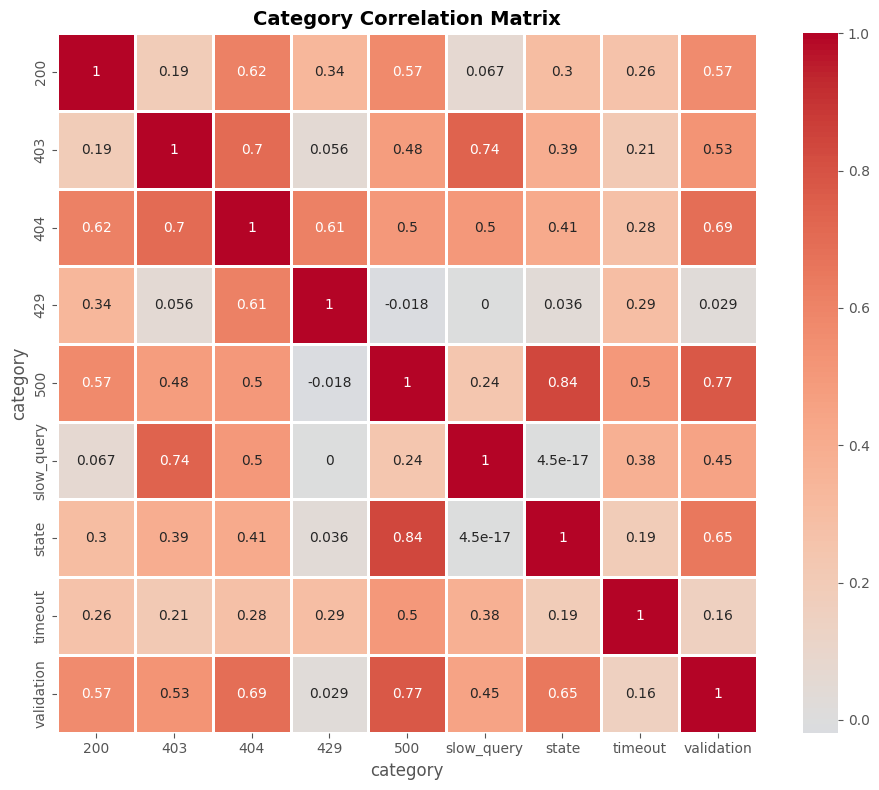

In [10]:
# %% [markdown]
# ## 🔄 Error Pattern Analysis

# %% [code]
# Find error sequences and patterns
def find_error_sequences(df, window_minutes=5):
    """Find sequences of errors within time window"""
    
    df_sorted = df.sort_values('timestamp')
    sequences = []
    
    for i, row in df_sorted.iterrows():
        window_end = row['timestamp'] + timedelta(minutes=window_minutes)
        window_errors = df_sorted[
            (df_sorted['timestamp'] > row['timestamp']) & 
            (df_sorted['timestamp'] <= window_end)
        ]
        
        if len(window_errors) >= 3:  # At least 3 errors in window
            sequences.append({
                'start_time': row['timestamp'],
                'end_time': window_end,
                'error_count': len(window_errors),
                'categories': window_errors['category'].tolist(),
                'error_types': window_errors['error_type'].tolist()
            })
    
    return pd.DataFrame(sequences)

# Find sequences
sequences = find_error_sequences(df)

if len(sequences) > 0:
    print(f"✅ Found {len(sequences)} error sequences")
    print("\nTop sequences:")
    print(sequences.nlargest(5, 'error_count')[['start_time', 'error_count', 'categories']])
else:
    print("No significant error sequences found")

# Correlation matrix
print("\n" + "="*60)
print("ERROR CORRELATION MATRIX")
print("="*60)

# Create correlation matrix
error_matrix = pd.crosstab(df['timestamp'].dt.floor('5min'), df['category'])
correlation_matrix = error_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Category Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

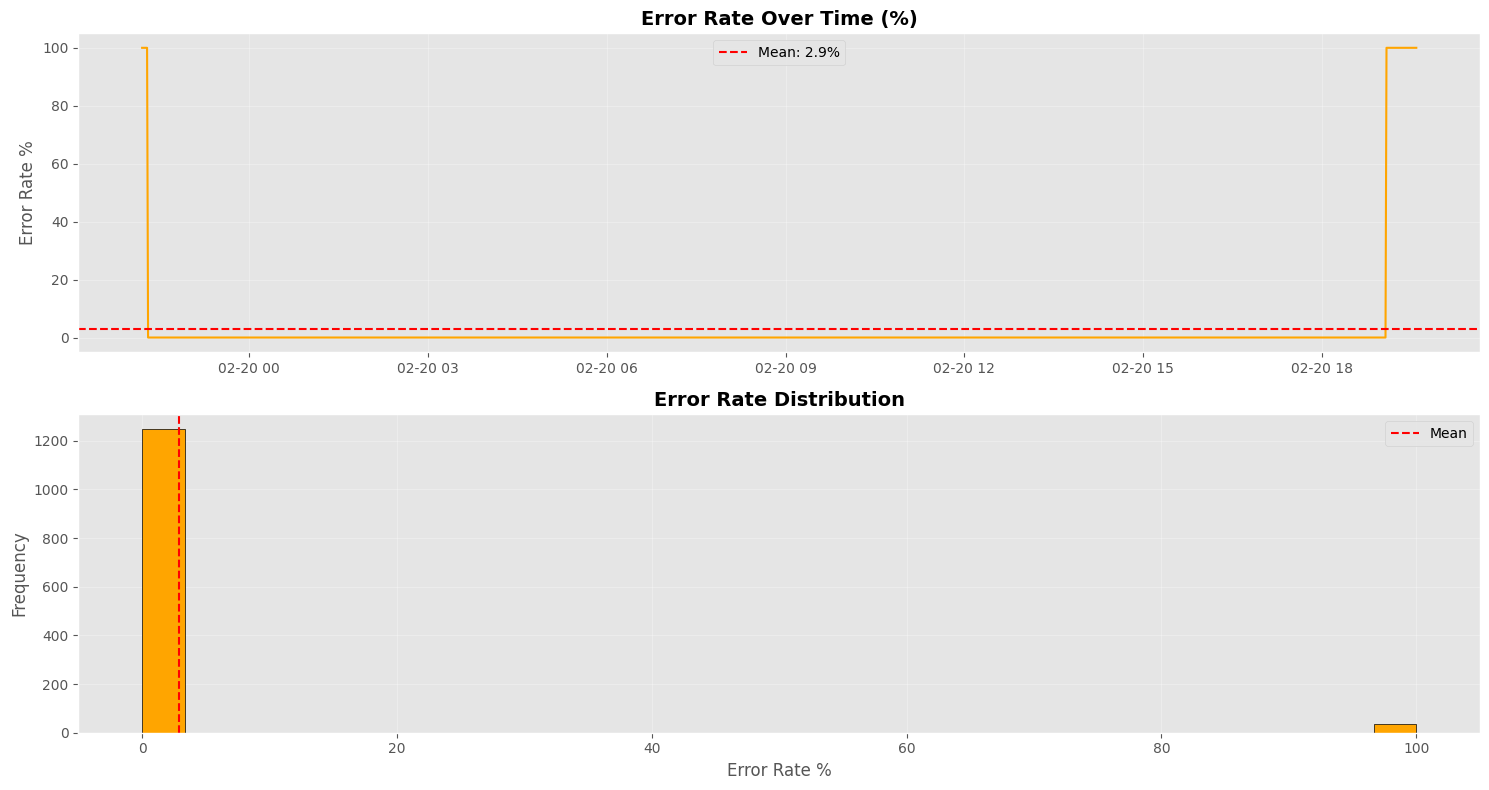

📊 Average Error Rate: 2.88%
📊 Max Error Rate: 100.00%
📊 Min Error Rate: 0.00%


In [11]:
# %% [markdown]
# ## ⏱️ Performance Metrics

# %% [code]
# Calculate error rates over time
error_rates = df.groupby('minute').agg({
    'error_type': lambda x: (x != '200').sum() / len(x) * 100
}).rename(columns={'error_type': 'error_rate'})

# Fill missing
error_rates = error_rates.reindex(full_range, fill_value=0)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(error_rates.index, error_rates['error_rate'], color='orange')
axes[0].axhline(y=error_rates['error_rate'].mean(), color='red', linestyle='--', label=f"Mean: {error_rates['error_rate'].mean():.1f}%")
axes[0].set_title('Error Rate Over Time (%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Error Rate %')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error rate distribution
axes[1].hist(error_rates['error_rate'].dropna(), bins=30, edgecolor='black', color='orange')
axes[1].axvline(x=error_rates['error_rate'].mean(), color='red', linestyle='--', label='Mean')
axes[1].set_title('Error Rate Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Error Rate %')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Average Error Rate: {error_rates['error_rate'].mean():.2f}%")
print(f"📊 Max Error Rate: {error_rates['error_rate'].max():.2f}%")
print(f"📊 Min Error Rate: {error_rates['error_rate'].min():.2f}%")

In [12]:
# %% [markdown]
# ## 💾 Export Data for ML

# %% [code]
def prepare_ml_dataset(df, window_minutes=5):
    """Prepare dataset for machine learning"""
    
    # Create features
    features = []
    labels = []
    
    for minute in pd.date_range(
        start=df['timestamp'].min(), 
        end=df['timestamp'].max(), 
        freq=f'{window_minutes}min'
    ):
        window_end = minute + timedelta(minutes=window_minutes)
        window_data = df[
            (df['timestamp'] >= minute) & 
            (df['timestamp'] < window_end)
        ]
        
        if len(window_data) > 0:
            feature = {
                'timestamp': minute,
                'total_events': len(window_data),
                'error_count': len(window_data[window_data['error_type'] != '200']),
                'success_count': len(window_data[window_data['error_type'] == '200']),
                'unique_categories': window_data['category'].nunique(),
                'unique_errors': window_data['error_type'].nunique(),
            }
            
            # Add category counts
            for category in df['category'].unique():
                feature[f'cat_{category}'] = len(window_data[window_data['category'] == category])
            
            # Add error type counts for top errors
            top_errors = df['error_type'].value_counts().head(5).index
            for error in top_errors:
                feature[f'err_{error}'] = len(window_data[window_data['error_type'] == error])
            
            features.append(feature)
            
            # Label: 1 if error_rate > threshold
            error_rate = feature['error_count'] / feature['total_events'] if feature['total_events'] > 0 else 0
            labels.append(1 if error_rate > 0.3 else 0)  # 30% error rate threshold
    
    ml_df = pd.DataFrame(features)
    ml_df['label'] = labels
    
    return ml_df

# Prepare ML dataset
ml_data = prepare_ml_dataset(df)
print(f"✅ ML Dataset prepared: {ml_data.shape}")
print(f"✅ Features: {ml_data.columns.tolist()}")
print(f"✅ Class distribution:\n{ml_data['label'].value_counts()}")

# Save to CSV
ml_data.to_csv('anomaly_training_data.csv', index=False)
print("\n✅ Saved to 'anomaly_training_data.csv'")

# Show sample
ml_data.head()

✅ ML Dataset prepared: (9, 20)
✅ Features: ['timestamp', 'total_events', 'error_count', 'success_count', 'unique_categories', 'unique_errors', 'cat_slow_query', 'cat_200', 'cat_500', 'cat_403', 'cat_404', 'cat_validation', 'cat_timeout', 'cat_429', 'cat_state', 'err_HTTP', 'err_BUSINESS', 'err_EXTERNAL', 'err_PERFORMANCE', 'label']
✅ Class distribution:
label
1    9
Name: count, dtype: int64

✅ Saved to 'anomaly_training_data.csv'


,timestamp,total_events,error_count,success_count,unique_categories,unique_errors,cat_slow_query,cat_200,cat_500,cat_403,cat_404,cat_validation,cat_timeout,cat_429,cat_state,err_HTTP,err_BUSINESS,err_EXTERNAL,err_PERFORMANCE,label
0,2026-02-19 22:12:00.691635,97,97,0,7,4,10,58,3,7,5,6,8,0,0,73,6,8,10,1
1,2026-02-19 22:17:00.691635,11,11,0,4,3,1,5,2,0,0,0,3,0,0,7,0,3,1,1
2,2026-02-20 19:02:00.691635,19,19,0,5,4,1,13,0,0,0,2,1,2,0,15,2,1,1,1
3,2026-02-20 19:07:00.691635,102,102,0,7,4,5,71,3,7,9,4,3,0,0,90,4,3,5,1
4,2026-02-20 19:12:00.691635,95,95,0,9,4,2,57,7,4,6,5,8,3,3,77,8,8,2,1


In [13]:
# %% [markdown]
# ## 📋 Summary Report

# %% [code]
print("="*80)
print("ANOMALY DETECTION DATA ANALYSIS REPORT")
print("="*80)
print(f"\nReport Generated: {datetime.now()}")
print(f"Data Source: test.db")
print(f"Analysis Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total Records: {len(df)}")

print("\n" + "-"*80)
print("KEY METRICS")
print("-"*80)
print(f"1. Average Events per Minute: {len(df) / (len(minute_data)):.2f}")
print(f"2. Error Rate: {errors/total*100:.2f}%")
print(f"3. Unique Error Categories: {df['category'].nunique()}")
print(f"4. Unique Error Types: {df['error_type'].nunique()}")
print(f"5. Peak Hour: {df['hour'].mode()[0]}:00")
print(f"6. Most Common Error: {df['error_type'].mode()[0]}")
print(f"7. Most Common Category: {df['category'].mode()[0]}")
print(f"8. Anomaly Rate: {len(anomaly)/len(minute_anomalies)*100:.2f}%")

print("\n" + "-"*80)
print("ANOMALY INSIGHTS")
print("-"*80)
print("✅ High severity anomalies detected at:")
for idx, row in anomaly.nlargest(5, 'count').iterrows():
    print(f"   • {idx}: {row['count']} events (Z-score: {row['z_score']:.2f})")

print("\n" + "-"*80)
print("RECOMMENDATIONS")
print("-"*80)
print("1. Set alert threshold at 2.5σ for production")
print("2. Monitor error rates above 30%")
print("3. Watch for patterns in HTTP 500 errors")
print("4. Investigate external API timeouts")
print("5. Database connection errors need attention")

print("\n" + "="*80)

# Close connection
conn.close()
print("\n✅ Analysis complete! Connection closed.")

ANOMALY DETECTION DATA ANALYSIS REPORT

Report Generated: 2026-02-22 11:34:13.794104
Data Source: test.db
Analysis Period: 2026-02-19 22:12:00.691635 to 2026-02-20 19:35:03.727096
Total Records: 612

--------------------------------------------------------------------------------
KEY METRICS
--------------------------------------------------------------------------------
1. Average Events per Minute: 0.48
2. Error Rate: 100.00%
3. Unique Error Categories: 9
4. Unique Error Types: 4
5. Peak Hour: 19:00
6. Most Common Error: HTTP
7. Most Common Category: 200
8. Anomaly Rate: 2.73%

--------------------------------------------------------------------------------
ANOMALY INSIGHTS
--------------------------------------------------------------------------------
✅ High severity anomalies detected at:
   • 2026-02-19 22:13:00: 28 events (Z-score: 9.51)
   • 2026-02-20 19:12:00: 25 events (Z-score: 8.47)
   • 2026-02-19 22:12:00: 24 events (Z-score: 8.12)
   • 2026-02-20 19:13:00: 23 events (Z-

In [14]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier
import pandas as pd

# Load the prepared dataset
df_ml = pd.read_csv('anomaly_training_data.csv')

# Train Isolation Forest
model = IsolationForest(contamination=0.1, random_state=42)
features = df_ml.drop(['timestamp', 'label'], axis=1)
model.fit(features)

# Predict anomalies
predictions = model.predict(features)

In [18]:
predictions

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1])

In [15]:
# Create thresholds based on your data
thresholds = {
    'events_per_minute': 20,  # Based on peak of 28
    'error_rate': 30,  # Percentage
    'unique_categories': 4,  # Normal variation
}

def monitor_new_errors(new_errors):
    """Real-time anomaly detection"""
    if len(new_errors) > thresholds['events_per_minute']:
        alert("⚠️ High event volume detected!")

In [16]:
# Add more error types for better training
ERROR_TYPES = {
    'DATABASE': ['connection', 'timeout', 'constraint', 'deadlock'],
    'NETWORK': ['dns', 'connection_refused', 'timeout'],
    'APPLICATION': ['null_pointer', 'index_error', 'value_error'],
    'SECURITY': ['auth_failed', 'permission_denied', 'rate_limit']
}

In [17]:
class AnomalyAlert:
    def __init__(self, threshold=2.5):
        self.threshold = threshold
        self.baseline_stats = {
            'mean_events': minute_data['count'].mean(),
            'std_events': minute_data['count'].std()
        }
    
    def check_anomaly(self, current_events):
        z_score = (current_events - self.baseline_stats['mean_events']) / self.baseline_stats['std_events']
        if abs(z_score) > self.threshold:
            return True, z_score
        return False, z_score

In [19]:
from langchain_community.document_loaders import JSONLoader

loader = JSONLoader(
    file_path="events.json",
    jq_schema=".[]",     # root array iterate
    text_content=False
)

docs = loader.load()

In [20]:
docs

[Document(metadata={'source': 'C:\\Users\\DeLL\\Desktop\\Ai-assistant-distributors\\AI-Assisted-Distributed-Log-Monitoring-System\\Agent-sdk_v2\\events.json', 'seq_num': 1}, page_content='{"ip": "127.0.0.1", "api_key": "demo-key", "received_at": "2026-02-20T13:00:53.883351", "payload": {"batch_meta": {"environment": "production", "event_count": 2, "project": "client-test-app", "schema_version": "1.0", "sdk_version": "2.0.0", "sent_at": "2026-02-20T13:00:53.882163+00:00"}, "events": [{"event": {"category": "APPLICATION", "data": {"file": "c:\\\\Users\\\\DeLL\\\\Desktop\\\\Ai-assistant-distributors\\\\AI-Assisted-Distributed-Log-Monitoring-System\\\\Agent-sdk_v2\\\\client_app.py", "level": "ERROR", "line": 129, "logger_name": "root", "message": "This is a test error log", "stacktrace": null}, "metrics": {}, "severity": "HIGH", "status": "FAILURE", "type": "LOG"}, "identity": {"app_version": "1.0.0", "hostname": "DESKTOP-N00M686", "instance_id": "8ed293ae-de5d-458a-a980-ad5fa32eb63d", "os

In [29]:
docs[0].page_content

'{"ip": "127.0.0.1", "api_key": "demo-key", "received_at": "2026-02-20T13:00:53.883351", "payload": {"batch_meta": {"environment": "production", "event_count": 2, "project": "client-test-app", "schema_version": "1.0", "sdk_version": "2.0.0", "sent_at": "2026-02-20T13:00:53.882163+00:00"}, "events": [{"event": {"category": "APPLICATION", "data": {"file": "c:\\\\Users\\\\DeLL\\\\Desktop\\\\Ai-assistant-distributors\\\\AI-Assisted-Distributed-Log-Monitoring-System\\\\Agent-sdk_v2\\\\client_app.py", "level": "ERROR", "line": 129, "logger_name": "root", "message": "This is a test error log", "stacktrace": null}, "metrics": {}, "severity": "HIGH", "status": "FAILURE", "type": "LOG"}, "identity": {"app_version": "1.0.0", "hostname": "DESKTOP-N00M686", "instance_id": "8ed293ae-de5d-458a-a980-ad5fa32eb63d", "os": "Windows", "os_version": "11", "process_id": 17980, "python_version": "3.12.2", "region": "unknown"}, "meta": {"environment": "production", "project": "client-test-app", "schema_versio

In [1]:
import pandas as pd

In [2]:
df = pd.read_json('events.json')

In [ ]:
event = df['payload'][0]['events'][0]['event']
str = ''
for key, value in event.items():
    if key != "data":
        m = f"{key} is {value} | "
        str += m
    else:
        
        for k, v in value.items():
            n = f'{k} is {v} - '
            str = str + n
print(str)      

category is APPLICATION | file is c:\Users\DeLL\Desktop\Ai-assistant-distributors\AI-Assisted-Distributed-Log-Monitoring-System\Agent-sdk_v2\client_app.py . level is ERROR . line is 129 . logger_name is root . message is This is a test error log . stacktrace is None . metrics is {} | severity is HIGH | status is FAILURE | type is LOG | 
